<a href="https://colab.research.google.com/github/E-leg/Project_Tropical_Cyclones/blob/main/tc_sar_stats_with_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Statistics of Tropical Cyclones (TCs) wind fields derived from Synthetic Aperture Radar (SAR) imagery


### Description

The dataset consists of 341 files in one global xarray.Dataset stored in .zarr format. Each file contains a SAR acquisition of one TC at one instant time, as well as the computed wind field associated with the satellite signal. Each file also contains additional information, such as the storm name, ID, and category (= category at the time of the acquisition).

The specificity of this dataset (compared to other TC datasets) is its spatial resolution, which reaches 1 km in both x and y directions. The counterpart is its temporal resolution, which is very low: TC images are acquired when the (polar-orbiting) satellite overpasses a TC (and only if the operational chain decided to put the sensor on at this moment), which leads to an irregular sampling in time. 

The goal of the project is to compute some statistical properties about the TCs of the dataset. This includes statistics about:

- GROUP 1: covariance matrix of the wind fields by Saffir-Simpson category;

- GROUP 2: spatial and temporal coverage of the TCs (basins, seasons), mean wind field by Saffir-Simpson category, as well as statistical distribution of some important metrics (Vmax, Rmax, R64, R50, R34);

### Imports 

In [ ]:
### INSTALLATION
!pip install --upgrade tqdm gcsfs zarr dask xarray scipy datetime

In [ ]:
from tqdm import tqdm
import gcsfs
import zarr
import dask as da
from collections import Counter

import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from scipy.interpolate import griddata
from datetime import datetime
from numpy.linalg import eig

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

### Dataset

In [ ]:
# OPEN DATASET
fs     = gcsfs.GCSFileSystem(project='ds2class-2021', token='anon', access='read_only')
gcsmap = fs.get_mapper("project10_tc_sar/zarr_data/tc_sar_data.zarr")
ds_all = xr.open_zarr(gcsmap)
ds_all

<xarray.Dataset>
Dimensions:                                        (time: 341, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2012...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/35)
    across_wind_from_direction_component           (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_streaks_orientation_component      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_from_direction_component            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_streaks_orientation_component       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    tangential_wind_streaks_orientation_component  (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_from_direction                            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_speed                                     (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation_stddev                (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

### Plot function

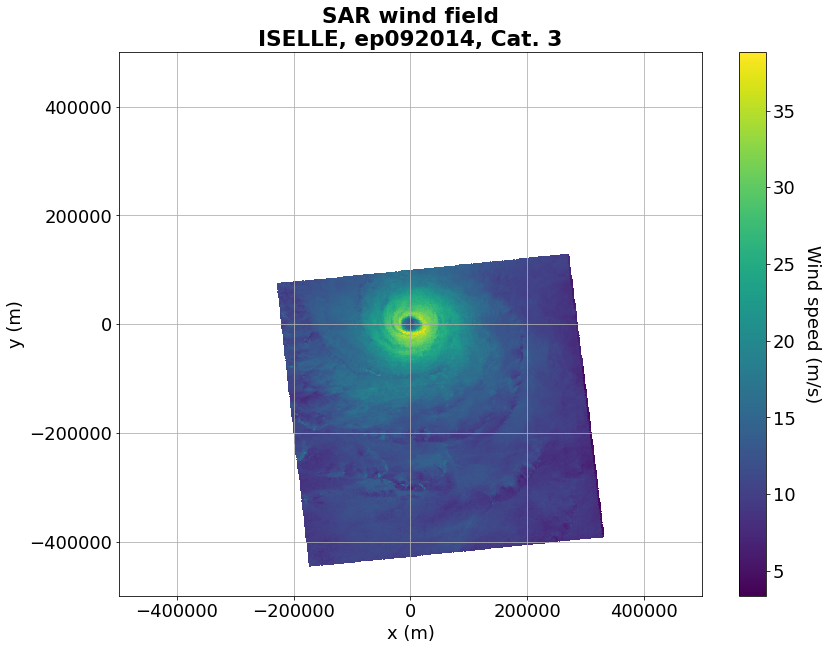

In [ ]:
### PLOTTING WIND FIELDS
def plot_wind_field(ds_all, time_idx):
    '''Given an xarray.Dataset object containing all the files (e.g 341) and a time index, plots the corresponding TC wind field using plt.pcolormesh().'''
    # Open figure
    fig, _ = plt.subplots()
    
    # Title
    name = ds_all.isel(time=time_idx)['storm_name'].values
    tcId = ds_all.isel(time=time_idx)['storm_id'].values
    cat  = int(ds_all.isel(time=time_idx)['cat'])
    plt.title('SAR wind field\n%s, %s, Cat. %i'%(name, tcId, cat), weight='bold')
    
    # Plot
    x, y = np.meshgrid(ds_all.isel(time=time_idx)['x'], ds_all.isel(time=time_idx)['y']) # Defining 2D coordinates
    plt.pcolormesh(x, y, ds_all.isel(time=time_idx)['wind_speed'])                       # Plot the wind field
    plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()                                   # Add axis legend
    plt.subplots_adjust(right=0.8)                                                       # Colorbar - line 1
    cbar = plt.colorbar()                                                                # Colorbar - line 2
    cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25     # Colorbar - line 3
    
plot_wind_field(ds_all, time_idx=9)

### Covariance

In [ ]:
# Get category for each image
cats = ds_all.cat.to_numpy()
Counter(cats)

Counter({0: 92, 1: 82, 2: 41, 3: 55, 4: 54, 5: 17})

In [ ]:
# Process dataset and get wind speed data
i_pix = 250000
crop_ds_all = ds_all.sel(x=slice(-i_pix, i_pix-1), y=slice(-i_pix, i_pix-1)) # Crop

n = 10
wind_speed = crop_ds_all.wind_speed[:,::n,::n].to_numpy() # Reduce data
wind_speed.shape

(341, 50, 50)

In [ ]:
plt.figure()
plt.plot()

In [ ]:
# Vectorize data
X = wind_speed.reshape(wind_speed.shape[0],-1)
X.shape

(341, 2500)

In [ ]:
# Group data by category
X_by_cat = [X[cats == i] for i in range(cats.max()+1)]
len(X_by_cat)

6

In [ ]:
# Center data
Xc_by_cat = [x - np.nanmean(x, axis=0) for x in X_by_cat]

# Compute covariance
compute_cov = lambda X : np.nanmean(np.array([np.outer(x,x) for x in X]), axis=0)
Cov_by_cat = [compute_cov(Xc) for Xc in Xc_by_cat]

Cov_by_cat[0].shape

In [ ]:
# Category
nc = 0

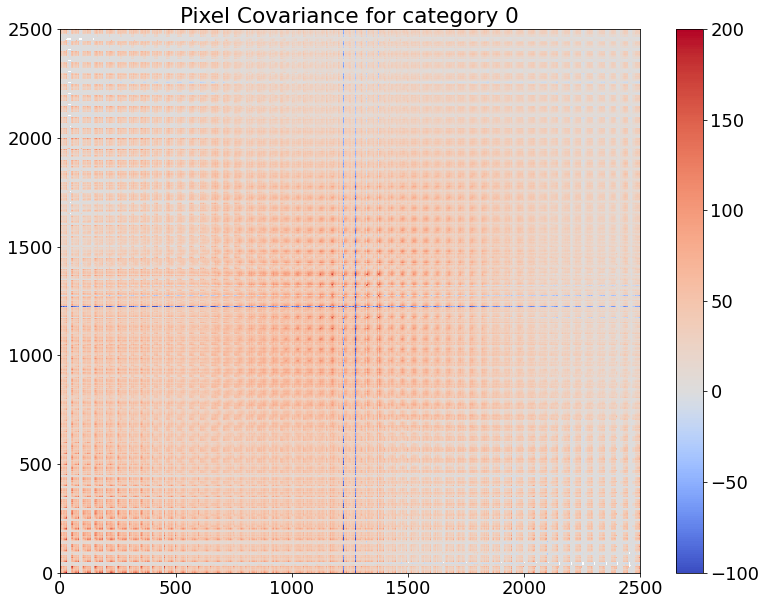

In [ ]:
# Plot covariance Matrix
plt.figure(figsize=(13,10))
plt.title(f'Pixel Covariance for category {nc}')
divnorm = colors.TwoSlopeNorm(vmin=-100, vcenter=0., vmax=200)
plt.pcolormesh(Cov_by_cat[nc], cmap="coolwarm", norm=divnorm)
plt.colorbar()
plt.show()
# Keep same clim for all cats

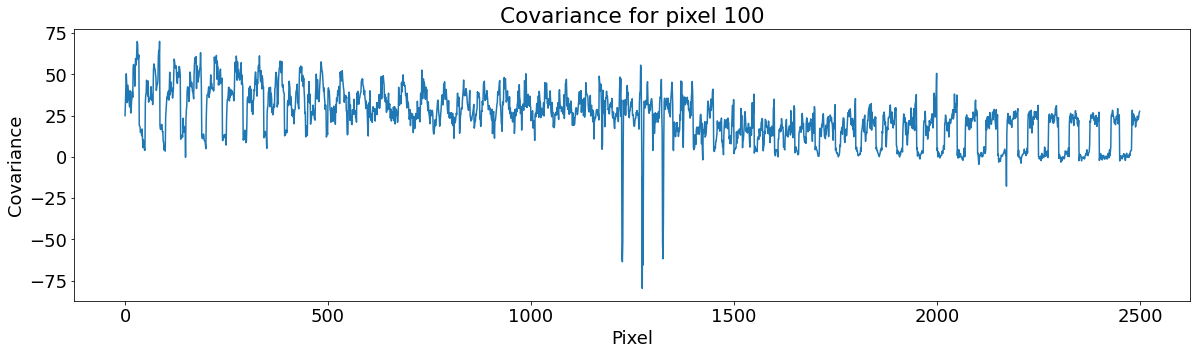

In [ ]:
# Plot covariance for one pixel
rand_index = 100
plt.figure(figsize=(20,5))
plt.plot(Cov_by_cat[nc][rand_index])
plt.title(f'Covariance for pixel {rand_index}')
plt.xlabel('Pixel')
plt.ylabel('Covariance')
plt.show()

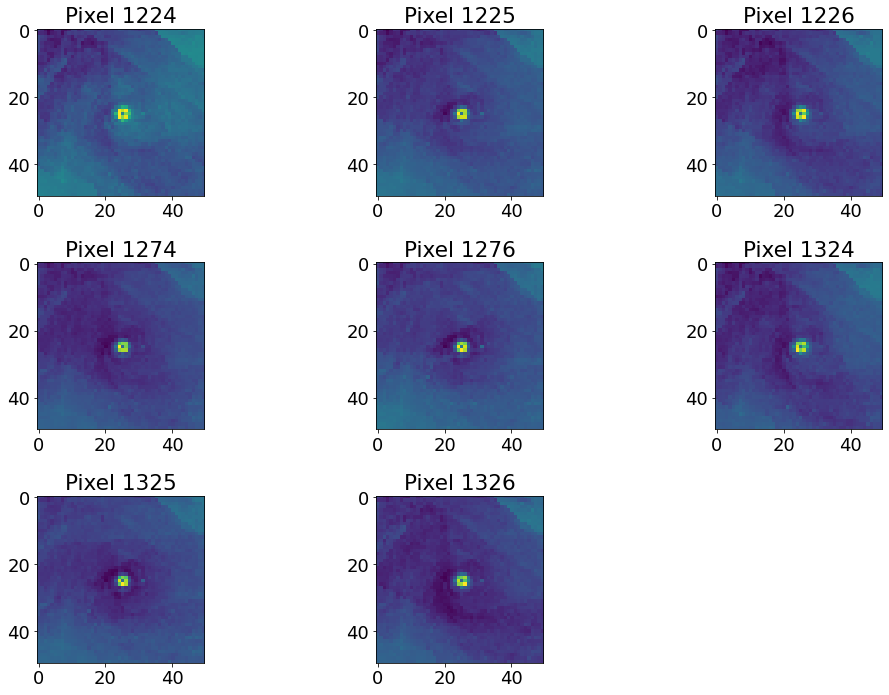

In [ ]:
# Plot covariance for pixel from blue line
threshold = -25
for i,ind in enumerate(np.where(Cov_by_cat[nc][rand_index] < threshold)[0]):
    plt.subplot(3,3,i+1)
    plt.title(f'Pixel {ind}')
    im = Cov_by_cat[nc][ind].reshape(50,50)
    plt.imshow(im)
plt.tight_layout()
plt.show()

### PCA

In [ ]:
# Eigen decomposition of covariance matrix
values, vectors = eig(np.nan_to_num(Cov_by_cat[nc]))
print(vectors.shape)
print(values.shape)

(2500, 2500)
(2500,)


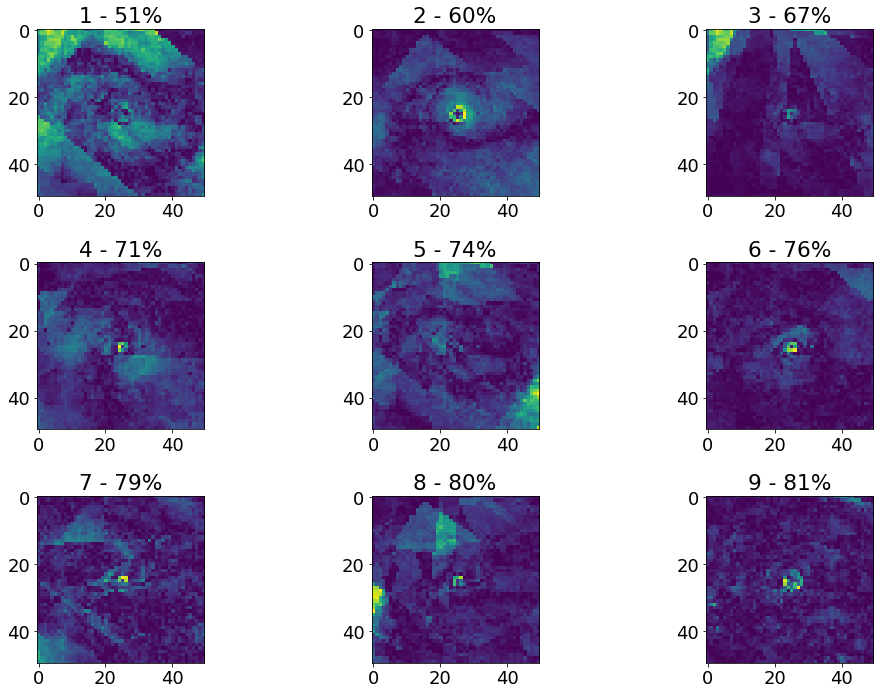

In [ ]:
# Plot the first eigen vectors
plt.figure()
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(abs(vectors.T[i,:]).reshape(50,50))
    explained_var = int(round((np.cumsum(abs(values[:i]))[-1] / abs(values).sum())*100))
    plt.title(f'{i} - {explained_var}%')
plt.tight_layout()
plt.show()

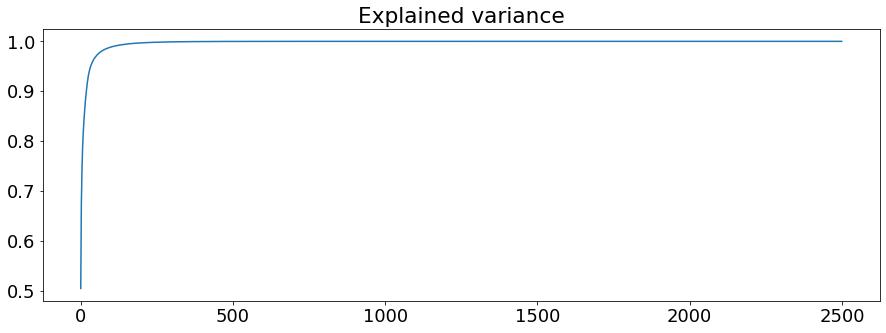

In [ ]:
# Explained variance
plt.figure(figsize=(15,5))
plt.title("Explained variance")
plt.plot(np.arange(len(v)), np.cumsum(abs(values)) / abs(values).sum())
plt.show()

In [ ]:
# Project data
P = np.dot(vectors.T, X_by_cat[nc].T)
P.shape

(2500, 92)